# About the data
Each training and test case represents a label (0-25) as a one-to-one map for each alphabetic letter A-Z (and no cases for 9=J or 25=Z because of gesture motions). The training data (27,455 cases) and test data (7172 cases) are approximately half the size of the standard MNIST but otherwise similar with a header row of label, pixel1,pixel2….pixel784 which represent a single 28x28 pixel image with grayscale values between 0-255. The original hand gesture image data represented multiple users repeating the gesture against different backgrounds.

The Sign Language MNIST data came from greatly extending the small number (1704) of the color images included as not cropped around the hand region of interest. To create new data, an image pipeline was used based on ImageMagick and included cropping to hands-only, gray-scaling, resizing, and then creating at least 50+ variations to enlarge the quantity. The modification and expansion strategy was filters ('Mitchell', 'Robidoux', 'Catrom', 'Spline', 'Hermite'), along with 5% random pixelation, +/- 15% brightness/contrast, and finally 3 degrees rotation. Because of the tiny size of the images, these modifications effectively alter the resolution and class separation in interesting, controllable ways.

In [1]:
# connecting drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# importing libraries
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from torchvision import models, transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image

# Loading the Dataset

In [3]:
# loading the datasets
df = pd.read_csv("/content/gdrive/MyDrive/AI/sign_mnist_train.csv")
df_test = pd.read_csv("/content/gdrive/MyDrive/AI/sign_mnist_test.csv")

In [4]:
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [5]:
df_test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


In [6]:
# checking unique values
# each unoque value respresent one letter in the alphabet
# exaple: 0 -> A
df['label'].unique()

array([ 3,  6,  2, 13, 16,  8, 22, 18, 10, 20, 17, 19, 21, 23, 24,  1, 12,
       11, 15,  4,  0,  5,  7, 14])

In [7]:
# getting information on the dataset
# in total there are 27455 entries
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27455 entries, 0 to 27454
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 164.4 MB


In [8]:
# checking for null values
df.isna().sum().sum()

0

# Visualization

In [9]:
# creating dictionary of the labels and respective letters
# it will help to identify if we correctly show label and its respective image
alph_dict = {
  0: 'A',
  1: 'B',
  2: 'C',
  3: 'D',
  4: 'E',
  5: 'F',
  6: 'G',
  7: 'H',
  8: 'I',
  9: 'J',
  10: 'K',
  11: 'L',
  12: 'M',
  13: 'N',
  14: 'O',
  15: 'P',
  16: 'Q',
  17: 'R',
  18: 'S',
  19: 'T',
  20: 'U',
  21: 'V',
  22: 'W',
  23: 'X',
  24: 'Y',
  25: 'Z'
  }

In [10]:
# reshaping the image data to 28x28 and plotting it
def plot_sign(row_num):
  first_image = df.iloc[row_num, 1:].values.reshape(28, 28)
  plt.figure(figsize = (1.5,2))
  plt.imshow(first_image, cmap='gray')
  plt.title(f"Label: {alph_dict[df.iloc[row_num, 0]]}")
  plt.axis('off')
  plt.show()

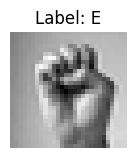

In [11]:
plot_sign(98)

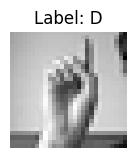

In [12]:
plot_sign(8)

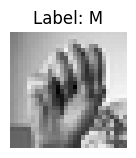

In [13]:
plot_sign(31)

# Preprocessing

In [14]:
# assigning and reshaping train and test data
X = df.drop('label', axis=1).values
X = X.reshape(-1, 1, 28, 28).astype('float32')
y = df['label'].values

X_test = df_test.drop('label', axis=1).values
X_test = X_test.reshape(-1, 1, 28, 28).astype('float32')
y_test = df_test['label'].values

In [15]:
# normalizing the images
X /= 255.0
X_test /= 255.0

In [16]:
# splitting into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# converting to PyTorch tensors
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

In [18]:
# creating data loaders to feed into the model
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

# Resnet

In [19]:
# loading a pre-trained ResNet model
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 150MB/s]


In [20]:
# modifying the first layer to accept 1 channel instead of 3
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [21]:
# changing the output layer to match the number of classes (ASL alphabets excluding J and Z, 24 classes)
model.fc = nn.Linear(model.fc.in_features, 25)

In [22]:
# for faster computation
device= torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
# initializing loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and Validation

In [24]:
# training and validation
def train(model, criterion, optimizer, train_loader, val_loader, epochs):
    train_losses, val_losses = [], []

    # looping through the 15 epochs
    for epoch in range(epochs):
        # setting model to training mode
        model.train()
        running_loss = 0.0

        # iterating through the training data
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            # Zero the parameter gradients
            optimizer.zero_grad()

            # forward pass
            outputs = model(images)
            # calculating the loss
            loss = criterion(outputs, labels)
            # backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # calculating and storing the average training loss for the current epoch
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation loss
        # setting model to evaluation mode
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0

        # disabling gradient computation during validation
        with torch.no_grad():
            # iterating through validation data
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(val_loader)
        val_losses.append(val_loss)

        val_accuracy = 100 * correct / total



        # calculating and storing the average validation loss for the current epoch
        print(f"Epoch {epoch+1}/{epochs} - Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    return train_losses, val_losses

# Train the model
train_losses, val_losses = train(model, criterion, optimizer, train_loader, val_loader, epochs=15)


Epoch 1/15 - Training Loss: 0.5277, Validation Loss: 0.4626, Validation Accuracy: 88.20%
Epoch 2/15 - Training Loss: 0.1006, Validation Loss: 0.1701, Validation Accuracy: 95.21%
Epoch 3/15 - Training Loss: 0.0769, Validation Loss: 0.0278, Validation Accuracy: 99.25%
Epoch 4/15 - Training Loss: 0.0425, Validation Loss: 0.0310, Validation Accuracy: 99.13%
Epoch 5/15 - Training Loss: 0.0484, Validation Loss: 0.1150, Validation Accuracy: 96.72%
Epoch 6/15 - Training Loss: 0.0257, Validation Loss: 0.0085, Validation Accuracy: 99.71%
Epoch 7/15 - Training Loss: 0.0373, Validation Loss: 0.0283, Validation Accuracy: 99.25%
Epoch 8/15 - Training Loss: 0.0579, Validation Loss: 0.0135, Validation Accuracy: 99.58%
Epoch 9/15 - Training Loss: 0.0175, Validation Loss: 0.0009, Validation Accuracy: 100.00%
Epoch 10/15 - Training Loss: 0.0152, Validation Loss: 0.0011, Validation Accuracy: 99.96%
Epoch 11/15 - Training Loss: 0.0246, Validation Loss: 0.0012, Validation Accuracy: 99.98%
Epoch 12/15 - Trai

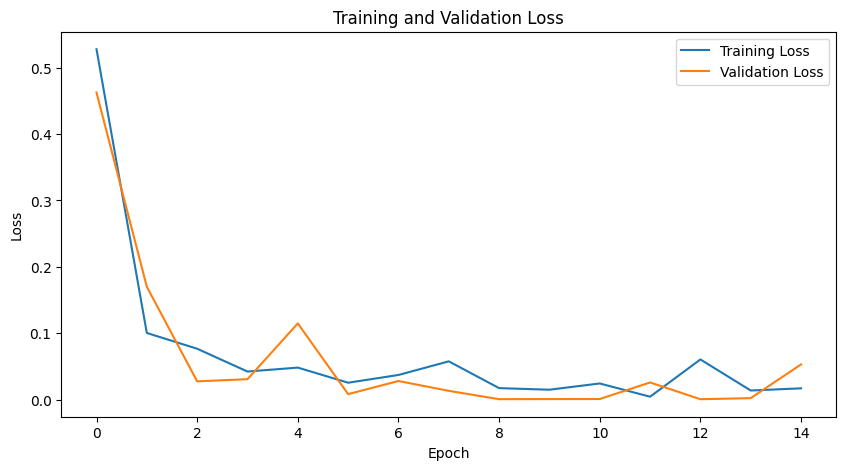

In [25]:
# Plot the training and validation losses
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Testing

In [26]:
# Function to evaluate the model on the test set
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # No need to track gradients for evaluation
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total

In [27]:
test_accuracy

95.18962632459565

In [28]:
import numpy as np


In [29]:
def load_image(image_path):
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
        transforms.Resize((28, 28)),  # Resize to match the model input
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize((0.5,), (0.5,))  # Normalize
    ])

    image = Image.open(image_path)
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    return image

In [30]:
def predict(model, image):
    model.eval()
    with torch.no_grad():
        image = image.to(device)
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        return predicted.item()

In [31]:
# funtion to plot images that we took
def plot_image(image,label):
  image = np.squeeze(image)
  plt.figure(figsize = (1.5,3))
  plt.imshow(image, cmap='gray')
  plt.title(f"Label: {label}")
  plt.axis('off')
  plt.show()

Predicted class: H


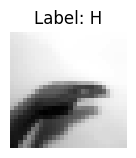

In [57]:
# Example usage
image_path = '/content/gdrive/MyDrive/AI/asl_imgs/H.jpeg'
image = load_image(image_path)
# converting PIL image to NumPy array
image_array = np.array(image)
# squeezing singleton dimensions if present
image_array = np.squeeze(image_array)
prediction = predict(model, image)
print(f'Predicted class: {alph_dict[prediction]}')
plot_image(image,alph_dict[prediction] )

Predicted class: L


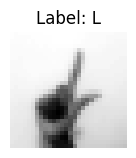

In [58]:
# Example usage
image_path = '/content/gdrive/MyDrive/AI/asl_imgs/L.jpeg'
image = load_image(image_path)
# converting PIL image to NumPy array
image_array = np.array(image)
# squeezing singleton dimensions if present
image_array = np.squeeze(image_array)
prediction = predict(model, image)
print(f'Predicted class: {alph_dict[prediction]}')
plot_image(image,alph_dict[prediction] )

Predicted class: P


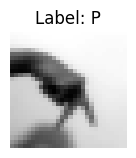

In [59]:
# Example usage
image_path = '/content/gdrive/MyDrive/AI/asl_imgs/P.jpeg'
image = load_image(image_path)
# converting PIL image to NumPy array
image_array = np.array(image)
# squeezing singleton dimensions if present
image_array = np.squeeze(image_array)
prediction = predict(model, image)
print(f'Predicted class: {alph_dict[prediction]}')
plot_image(image,alph_dict[prediction] )

Predicted class: V


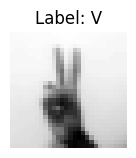

In [60]:
# Example usage
image_path = '/content/gdrive/MyDrive/AI/asl_imgs/V.jpeg'
image = load_image(image_path)
# converting PIL image to NumPy array
image_array = np.array(image)
# squeezing singleton dimensions if present
image_array = np.squeeze(image_array)
prediction = predict(model, image)
print(f'Predicted class: {alph_dict[prediction]}')
plot_image(image,alph_dict[prediction] )

Predicted class: B


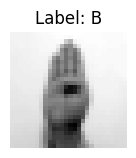

In [68]:
# Example usage
image_path = 'B.jpeg'
image = load_image(image_path)
# converting PIL image to NumPy array
image_array = np.array(image)
# squeezing singleton dimensions if present
image_array = np.squeeze(image_array)
prediction = predict(model, image)
print(f'Predicted class: {alph_dict[prediction]}')
plot_image(image,alph_dict[prediction] )

Predicted class: L


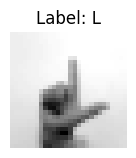

In [69]:
# Example usage
image_path = 'L.jpeg'
image = load_image(image_path)
# converting PIL image to NumPy array
image_array = np.array(image)
# squeezing singleton dimensions if present
image_array = np.squeeze(image_array)
prediction = predict(model, image)
print(f'Predicted class: {alph_dict[prediction]}')
plot_image(image,alph_dict[prediction] )

Predicted class: O


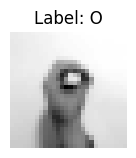

In [70]:
# Example usage
image_path = 'O.jpeg'
image = load_image(image_path)
# converting PIL image to NumPy array
image_array = np.array(image)
# squeezing singleton dimensions if present
image_array = np.squeeze(image_array)
prediction = predict(model, image)
print(f'Predicted class: {alph_dict[prediction]}')
plot_image(image,alph_dict[prediction] )

Predicted class: Y


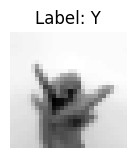

In [71]:
# Example usage
image_path = 'Y.jpeg'
image = load_image(image_path)
# converting PIL image to NumPy array
image_array = np.array(image)
# squeezing singleton dimensions if present
image_array = np.squeeze(image_array)
prediction = predict(model, image)
print(f'Predicted class: {alph_dict[prediction]}')
plot_image(image,alph_dict[prediction] )

# Saving the Model

In [ ]:
# import pickle
# pickle.dump(model, open('/content/drive/MyDrive/AI/model_resnet.pkl', 'wb'))
# model = pickle.load(open('/content/drive/MyDrive/AI/model_resnet.pkl', 'rb'))